<a href="https://colab.research.google.com/github/shinobu9/mipt-ml-course/blob/main/homeworks_advanced/assignment01_text_classification/assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 01

В данном задании мы рассмотрим задачу классификации текстов. Для достижения лучших результатов воспользуемся информативными призанковыми описаниями для слов.

In [1]:
# do not change the code in the block below
# __________start of block__________
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________

### Предобработка текста и токенизация

Предобработка практически аналогична рассмотренной на лекции. Библиотека `nltk` [link](https://www.nltk.org) широко используется при обработке текстов. По ссылке выше можно найти ее развернутое описание и документацию.

In [2]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

# Small check that everything is done properly
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


Следующие функции помогут вам с визуализацией процесса обучения сети.

In [3]:
# do not change the code in the block below
# __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
            
        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict
# __________end of block__________

### Задача №1. Мешок слов.

Воспользуйтесь классическим подходом к векторизации текстов: мешком слов. Для этого можно как воспользоваться `CountVectorizer` из `sklearn`, так и самостоятельно реализовать ее. Обращаем ваше внимание, в данной задаче используется лишь `k` наиболее часто встречаемых слов из обучающей части выборки.

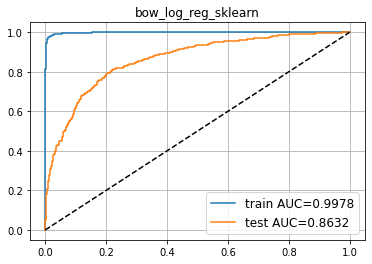

In [4]:
# do not change the code in the block below
# __________start of block__________

k = min(10000, len(set(' '.join(texts_train).split())))

counts = Counter(' '.join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Small check that everything is done properly if you are using local bow implementation
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

Результаты неплохие, но явно видно переобучение. Этот вывод можно сделать судя по значительному превосходству качества (AUC ROC) на train выборке относительно test. Более того, на обучающей выборке качество стремится к единице, в то время как на отложенной – значительно ниже, т.е. модель уловила множество зависимостей, свойственных лишь обучающей выборке. Базово проблема переобучения рассматривалась в [лекции №3](https://youtu.be/Ql00acFsEhE). Более подробно она еще не раз встретится при дальнейшем прохождении курса.

В данной задаче с переобучением мы разберемся в дальнейшем. Сейчас же реализуйте решение на основе логистической регрессии, но уже используя PyTorch. В результате вам должна быть доступна обученная модель, предсказывающая вероятности для двух классов. Качество на тестовой выборке должно не уступать логистической регрессии.

In [5]:
class LogReg(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogReg, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
        #  outputs = torch.sigmoid(self.linear(x))
        outputs = self.linear(x)
        return outputs

model = LogReg(k,2)

Не забывайте о функциях потерь: `nn.CrossEntropyLoss` объединяет в себе `LogSoftMax` и `NLLLoss`. Также не забывайте о необходимости перенести тензоры на используемый `device`.

In [6]:
# loss_function = torch.nn.NLLLoss()
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
X_train_bow_torch = torch.Tensor(X_train_bow).to(device)
X_test_bow_torch = torch.Tensor(X_test_bow).to(device)

y_train_torch = torch.Tensor(y_train).type(torch.LongTensor).to(device)
y_test_torch = torch.Tensor(y_test).type(torch.LongTensor).to(device)

Функция ниже поможет с обучением модели. Часть кода необходимо реализовать самостоятельно.

In [8]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model.forward(x_batch.to(device))
        
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

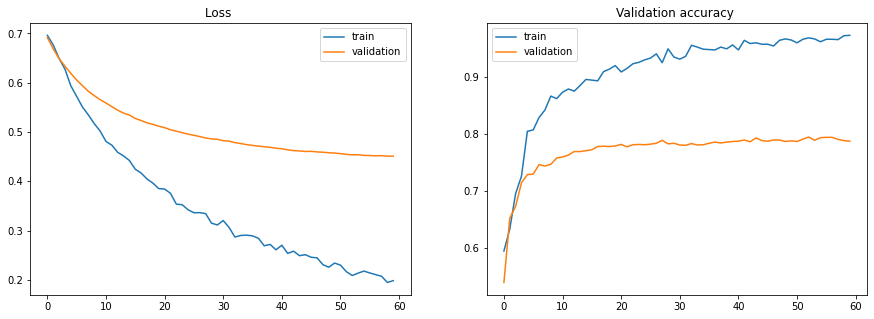

In [9]:
bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)

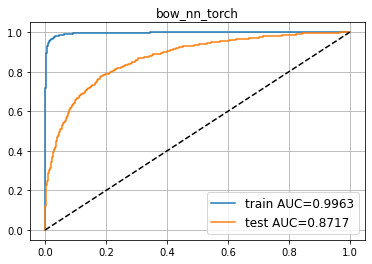

In [10]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

А теперь повторите процедуру обучения выше, но для различных значений `k` – размера словаря. В список results сохраните `AUC ROC` на тестовой части выборки для модели, обученной со словарем размера `k`.

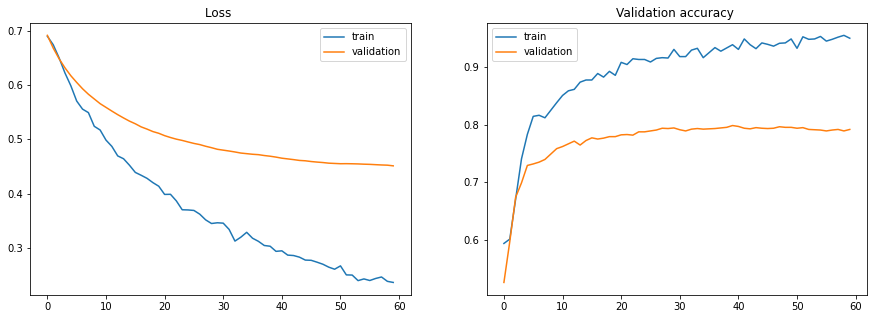

In [11]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

y_train_torch = torch.Tensor(y_train).type(torch.LongTensor).to(device)
y_test_torch = torch.Tensor(y_test).type(torch.LongTensor).to(device)

for k in vocab_sizes_list:
    model = LogReg(k,2)
    loss_function = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    counts = Counter(' '.join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]
    
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    X_train_bow_torch = torch.Tensor(X_train_bow).to(device)
    X_test_bow_torch = torch.Tensor(X_test_bow).to(device)

    bow_nn_model = train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, n_iterations=3000)
    predicted_probas_on_test_for_k_sized_dict = bow_nn_model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

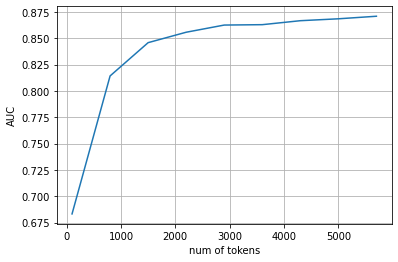

In [12]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['bow_k_vary'] = results
# __________end of block__________

### Задача №2: Использование TF-iDF признаков.

Для векторизации текстов также можно воспользоваться TF-iDF. Это позволяет исключить из рассмотрения многие слова, не оказывающие значимого влияния при оценке непохожести текстов.

Подробнее про TF-iDF можно почитать, например, [здесь](https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089).
Там же можно почитать о его самостоятельной реализации.

Ваша задача: векторизовать тексты используя TF-iDF (или `TfidfVectorizer` из `sklearn`, или реализовав его самостоятельно) и построить классификатор с помощью PyTorch, аналогичный задаче №1.

Затем также оцените качество классификации по AUC ROC для различных размеров словаря.

Качество классификации должно быть не ниже 0.86 AUC ROC.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit(texts_train)

X_train_tfidf = tfidf.transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

import scipy
X_train_tfidf_torch = torch.FloatTensor(scipy.sparse.csr_matrix.todense(X_train_tfidf)).to(device)
X_test_tfidf_torch = torch.FloatTensor(scipy.sparse.csr_matrix.todense(X_test_tfidf)).to(device)

y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

In [15]:
model = LogReg(X_train_tfidf_torch.shape[1], 2)

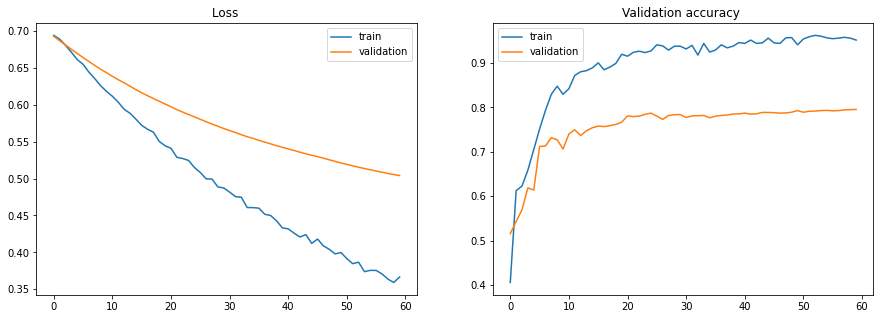

In [16]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

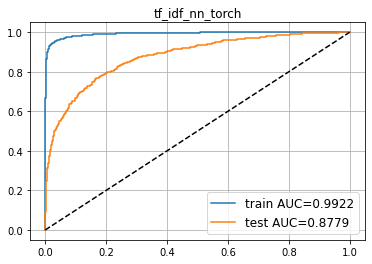

In [17]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)

assert out_dict['tf_idf_nn_torch_test'] >= out_dict['bow_nn_torch_test'], 'AUC ROC on test data should be better or close to BoW for TF-iDF features'
# __________end of block__________

Аналогично задаче №1 повторите процедуру обучения для различных значений `k` – размера словаря и сохраните `AUC ROC` на тестовой части выборки в список `results`.

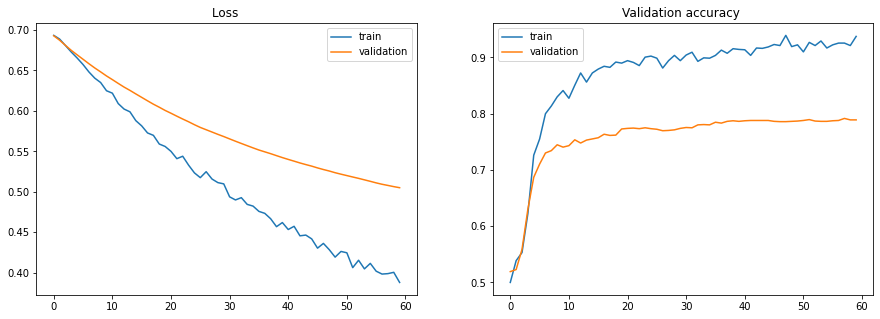

In [18]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    import scipy
    tfidf = TfidfVectorizer(max_features=k)
    tfidf.fit(texts_train)

    X_train_tfidf = tfidf.transform(texts_train)
    X_test_tfidf = tfidf.transform(texts_test)
    
    X_train_tfidf_torch = torch.FloatTensor(scipy.sparse.csr_matrix.todense(X_train_tfidf)).to(device)
    X_test_tfidf_torch = torch.FloatTensor(scipy.sparse.csr_matrix.todense(X_test_tfidf)).to(device)

    y_train_torch = torch.tensor(y_train).to(device)
    y_test_torch = torch.tensor(y_test).to(device)

    model = LogReg(k,2)
    loss_function = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    tf_idf_model = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)
    predicted_probas_on_test_for_k_sized_dict = tf_idf_model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

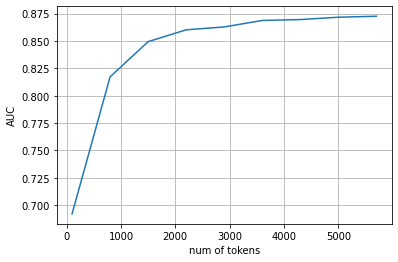

In [19]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.85, 'Best AUC ROC for TF-iDF should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['tf_idf_k_vary'] = results
# __________end of block__________

### Задача №3: Сравнение с Наивным Байесовским классификатором.

Классические модели все еще способны показать хороший результат во многих задачах. Обучите наивный байесовский классификатор на текстах, векторизованных с помощью BoW и TF-iDF и сравните результаты с моделями выше.

*Комментарий: обращаем ваше внимание, необходимо выбрать подходящее к данной задаче априорное распределение для признаков, т.е. выбрать верную версию классификатора из `sklearn`: `GaussianNB`, `MultinomialNB`, `ComplementNB`, `BernoulliNB`, `CategoricalNB`*

In [20]:
from sklearn.naive_bayes import MultinomialNB

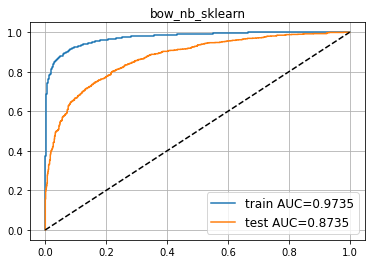

In [21]:
clf_nb_bow = MultinomialNB().fit(X_train_bow, y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

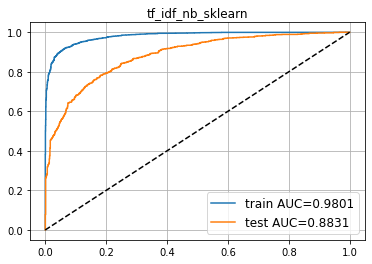

In [22]:
clf_nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [23]:
# do not change the code in the block below
# __________start of block__________
assert out_dict['tf_idf_nb_sklearn_test'] > out_dict['bow_nb_sklearn_test'],' TF-iDF results should be better'
assert out_dict['tf_idf_nb_sklearn_test'] > 0.86, 'TF-iDF Naive Bayes score should be above 0.86'
# __________end of block__________

### Задача №4: Использование предобученных эмбеддингов

Наконец, воспользуемся предобученными эмбеддингами из библиотеки `gensim`. В нем доступно несколько эмбеддингов, предобученных на различных корпусах текстов. Полный список можно найти [здесь](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). Напоминаем, что лучше использовать те эмбеддинги, которые были обучены на текстах похожей структуры.

Ваша задача: обучить модель (достаточно логистической регрессии или же двуслойной неронной сети), используя усредненный эмбеддинг для всех токенов в отзыве, добиться качества не хуже, чем с помощью BoW/TF-iDF и снизить степень переобучения (разницу между AUC ROC на обучающей и тестовой выборках).

In [24]:
import gensim.downloader as api
gensim_embedding_model = api.load('glove-wiki-gigaword-300')

[=================================================-] 98.5% 370.4/376.1MB downloaded


In [25]:
def text_to_average_embedding(text, gensim_embedding_model):
    sentence = []
    for t in text.split():
      try:
        vec = gensim_embedding_model.get_vector(t)
      except:
        pass
      else:
        sentence.append(vec)

    embedding_for_text = np.mean(np.array(sentence), axis=0)
    return embedding_for_text

In [26]:
X_train_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_train]
X_test_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_test]

assert len(X_train_emb[0]) == gensim_embedding_model.vector_size, 'Seems like the embedding shape is wrong'

In [27]:
X_train_emb_torch = torch.tensor(X_train_emb).to(device)
X_test_emb_torch = torch.tensor(X_test_emb).to(device)

y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

<ipython-input-27-9af6299a2ce8>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X_train_emb_torch = torch.tensor(X_train_emb).to(device)


In [28]:
model = LogReg(X_train_emb_torch.shape[1], 2)

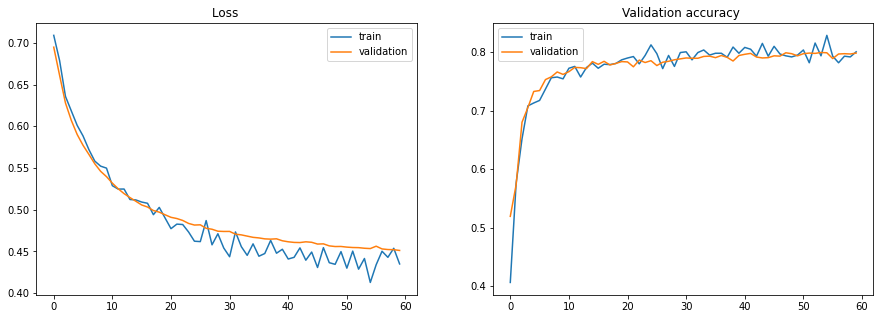

In [29]:
loss_function = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=3000)

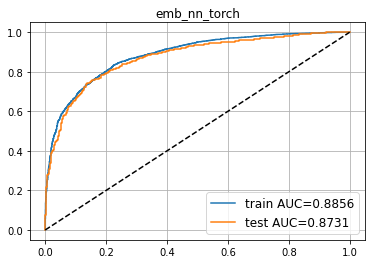

In [30]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
assert out_dict['emb_nn_torch_test'] > 0.87, 'AUC ROC on test data should be better than 0.86'
assert out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test'] < 0.1, 'AUC ROC on test and train data should not be different more than by 0.1'
# __________end of block__________

### Сдача задания
Запустите код ниже для генерации посылки и сдайте на проверку файл `submission_dict_101.npy`.

In [31]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_101.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_101.npy`')
# __________end of block__________

File saved to `submission_dict_101.npy`
